In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [3]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_rest_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_rest_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_rest_R104_norm.txt', sep=' ', names=headers)

In [4]:
R103_means = pd.read_csv('./datasets/fieldData_rest_R103_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_means = pd.read_csv('./datasets/fieldData_rest_R503_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_means = pd.read_csv('./datasets/fieldData_rest_R104_means.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

R103_scales = pd.read_csv('./datasets/fieldData_rest_R103_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R503_scales = pd.read_csv('./datasets/fieldData_rest_R503_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)
R104_scales = pd.read_csv('./datasets/fieldData_rest_R104_scales.txt', sep=' ', header=None).T.set_axis(headers, axis=1)

In [5]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000178,-0.000519,0.002788,-0.001416,-0.000398,0.000795,0.001038,-0.001166,0.000107,...,-0.001166,0.000361,-0.000233,-0.133664,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.219229
1,-1.027122,0.007117,-0.001178,0.002198,0.005526,-0.000435,0.000753,0.001038,-0.005757,0.000106,...,-0.005757,0.000359,-0.004720,-0.133664,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.184253
2,-1.027122,0.032932,-0.002102,0.001278,0.017426,-0.000476,0.000689,0.001038,-0.012206,0.000101,...,-0.012206,0.000352,-0.011717,-0.133658,-0.011824,0.009138,-0.152857,-0.045876,-0.14981,-0.184228
3,-1.027122,0.081009,-0.002795,0.000454,0.027343,-0.000304,0.000835,0.001038,-0.017039,0.000095,...,-0.017039,0.000342,-0.017983,-0.133624,-0.011825,0.009136,-0.152857,-0.045876,-0.14981,-0.183919
4,-1.027122,0.131517,-0.001906,0.001049,0.017426,0.000068,0.001191,0.001038,-0.010835,0.000099,...,-0.010835,0.000348,-0.013454,-0.133530,-0.011827,0.009135,-0.152857,-0.045876,-0.14981,-0.181174


In [6]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(38031441, 23)

In [7]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [8]:
M1.shape, M2.shape

((38031441, 10), (38031441, 13))

In [9]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [10]:
scale = R104_scales["Cs"]
mean = R104_means["Cs"]
dt = M4_104
dt_name = namestr(M4_104, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [11]:
dt.head()

,G1,G2,G3,G4,G5,G6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-0.000375,-0.000323,-0.000100,0.001489,-0.000781,0.000448,-0.117651,-0.001023,0.000472,-0.14459,-0.004092,-0.144046,-1.961971
1,0.003952,-0.000404,0.000002,0.001489,-0.002882,0.000506,-0.117651,-0.001023,0.000472,-0.14459,-0.004092,-0.144046,-0.251241
2,0.011275,-0.000614,-0.000557,0.001489,-0.005539,0.000449,-0.117649,-0.001023,0.000472,-0.14459,-0.004092,-0.144046,-0.172163
3,0.016601,0.000484,0.000480,0.001816,-0.007396,-0.000161,-0.117641,-0.001023,0.000472,-0.14459,-0.004092,-0.144046,-0.143082
4,0.012607,-0.001451,-0.001313,0.000836,-0.004245,0.000438,-0.117623,-0.001024,0.000472,-0.14459,-0.004092,-0.144046,-0.222984


In [12]:
#dt.to_csv(f'./{dt_name}.txt', sep=' ', index=False, encoding='utf-8', header=False)

In [13]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [14]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((25074357, 13), 16045121, 4013452, 5015784)

In [15]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [16]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 0.0166,  0.0041,  0.0060,  0.0021, -0.0058, -0.0047, -0.1176, -0.0010,
         0.0005, -0.1446, -0.0041, -0.1440, -0.1099], dtype=torch.float64)

In [17]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [19]:
PATH = f"./best_model_{dt_name}.pt"
device = torch.device("cuda")
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model.load_state_dict(torch.load(PATH))
model.eval()
#model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [20]:
pred = model(torch.from_numpy(test[:,:-1]))
pred.detach().numpy().shape 

(5015784, 1)

In [21]:
pred.detach().numpy() * scale.values[0]

array([[ 0.02509031],
       [-0.00803094],
       [-0.01131499],
       ...,
       [-0.01038718],
       [-0.00743988],
       [ 0.00176977]])

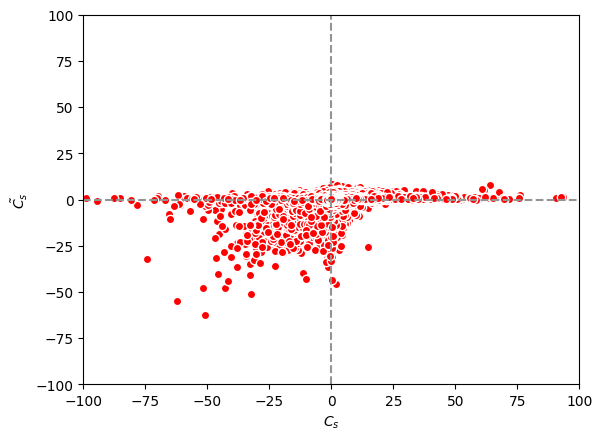

In [22]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation.png')

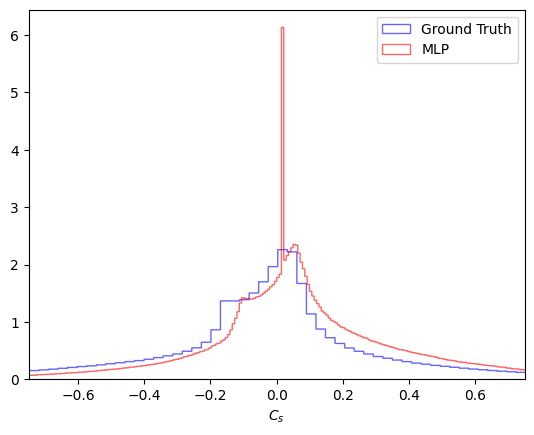

In [23]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density.png')